In [1]:
import numpy as np
import sys
import time
import os
import h5py
import os.path as op
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import array
from multiprocessing import Pool
import nyroglancer
from edgelist_methods import *
from itertools import product
from par_funcs import *
%matplotlib inline
sys.path.append('..')

# -------------------------------- parameters ---------------------------------------
gt_seg = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_seg_thick.h5'
gt_aff = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_aff.h5'
# pred_file = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/sample_A_x1_y1_z1_xy1.h5'
# pred_file = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/cutout_3k.h5'
pred_file = '/groups/turaga/home/turagas/turagalab/FROM_TIER2/singhc/train/output_200000/tstvol-1_2.h5'

out_folder = '/nobackup/turaga/singhc/par_zwshed_3/'
outname = out_folder+'out.h5'
threshes = [2000]
cmap = matplotlib.colors.ListedColormap(np.vstack(((0, 0, 0), np.random.rand(255, 3))))
NUM_WORKERS = 32
MAX_LEN = 200

# Divide Volumes, set up args

In [2]:
args,starts,ends,dims,num_vols = partition_subvols(pred_file,out_folder,max_len=MAX_LEN)

dims [432 432 432]
num_vols [3 3 3]
deltas [144 144 144]


# Call Watershed

In [ ]:
p = Pool(NUM_WORKERS)
p.map(zwshed_h5_par, args)

# Stitch

i,x,y,z 0 0 0 0
i,x,y,z 1 0 0 1
i,x,y,z 3 0 1 0
i,x,y,z 4 0 1 1
i,x,y,z 9 1 0 0
i,x,y,z 10 1 0 1
i,x,y,z 12 1 1 0
i,x,y,z 13 1 1 1
	filter merges...
	merging numbers, 4675 keys ... 


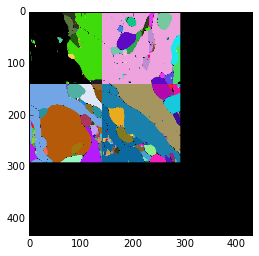

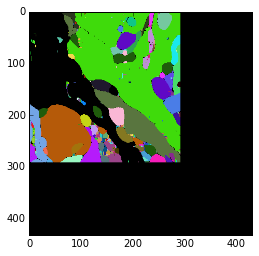

/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


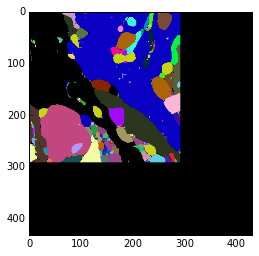

In [28]:
def stitch_and_save(args,starts,ends,dims,num_vols,outname,(X,Y,Z)=num_vols):
    if op.isfile(outname):
        os.remove(outname)
    f = h5py.File(outname, 'a')
    dset_seg = f.create_dataset('seg', dims, dtype='uint64', chunks=True)
    inc,re,merges,rgs,i_arr=0,{},{},{},[]
    # calc all merges, set dset_seg, rg with incrementing
    for x,y,z in product(range(X),range(Y),range(Z)):
        i = x*num_vols[1]*num_vols[2]+y*num_vols[2]+z
        i_arr.append(i)
        arg,s,e = args[i],starts[i],ends[i]
        basic_file = h5py.File(arg[-1]+'basic.h5','r')
        seg,rg = np.array(basic_file['seg']),np.array(basic_file['rg'])
        seg[seg!=0]+=inc
        rg[:,:2] += inc
        rgs[i] = rg
        inc = np.max(seg)
        print "i,x,y,z",i,x,y,z
        if not z==0: 
            re,merges = calc_merges(edge_mins=dset_seg[s[0]:e[0],s[1]:e[1],s[2]+3],edge_maxes=seg[:,:,3], re=re, merges=merges)
        if not y==0:
            re,merges = calc_merges(edge_mins=dset_seg[s[0]:e[0],s[1]+3,s[2]:e[2]],edge_maxes=seg[:,3,:],re=re,merges=merges)
        if not x==0:
            re,merges = calc_merges(edge_mins=dset_seg[s[0]+3,s[1]:e[1],s[2]:e[2]],edge_maxes=seg[3,:,:],re=re, merges=merges)
        dset_seg[s[0]:e[0],s[1]:e[1],s[2]:e[2]] = seg[:,:,:]


    merges_filtered = filter_merges(merges)
    plt.imshow(dset_seg[0, :, :], cmap=cmap)
    plt.show()
    rgs = merge(merges_filtered,rgs,i_arr,(args,starts,ends),f,max_val=inc)
    plt.imshow(dset_seg[0, :, :], cmap=cmap)
    plt.show()
    renum,seg_sizes,rgs = renum_all(f['seg'],rgs,i_arr,(args,starts,ends),f)
    plt.imshow(dset_seg[0, :, :], cmap=cmap)
    plt.show()


    # save
    dset_seg_sizes = f.create_dataset('seg_sizes', data=np.array(seg_sizes))
    for key in rgs:
        rg_dset = f.create_dataset('rg_'+str(key),data=np.array(rgs[key]))
    dset_starts = f.create_dataset('starts',data=np.array(starts))
    dset_ends = f.create_dataset('ends',data=np.array(ends))                               
    f.close()
X,Y,Z = (2,2,2)
stitch_and_save(args,starts,ends,dims,num_vols,outname,(X,Y,Z))

# Agglomeration

In [29]:
def merge_by_thresh(seg,seg_sizes,rg,thresh):
    re = {}
    seg_max = np.max(seg)
    print "calculating renums..."
    for i in range(rg.shape[0]):
        n1,n2,w = rg[i,:]
        size = w*w*thresh
        if seg_sizes[n1] < size or seg_sizes[n2] < size:
            re[n2]=n1
            seg_sizes[n1]+=seg_sizes[n2]
            seg_sizes[n2]+=seg_sizes[n1]
    re_filtered = {}
    print "filtering renums..."
    for key in re:
        print key,val
        val = re[key]
        while val in re:
            val = re[val]
        if key < seg_max and val < seg_max:
            re_filtered[key] = val
    print "renumbering..."
    mp = np.arange(0,seg_max+1,dtype='uint64')
    mp[re_filtered.keys()] = re_filtered.values()
    seg = mp[seg]
    return seg

num,thresh = 0,2000
f = h5py.File(outname, 'a')
s,e = f['starts'][num],f['ends'][num]
seg = f['seg'][s[0]:e[0],s[1]:e[1],s[2]:e[2]]
seg_sizes = np.array(f['seg_sizes'])
rg = np.array(f['rg_'+str(num)])
f.close()

seg_merged = merge_by_thresh(seg,seg_sizes,rg,thresh)
plt.subplot(1,2,1)
plt.imshow(seg[0,:,:], cmap=cmap)
plt.subplot(1,2,2)
plt.imshow(seg_merged[0,:,:], cmap=cmap)

calculating renums...
filtering renums...


/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KeyboardInterrupt: 

# Visualize

In [ ]:
v = nyroglancer.Viewer()
v.set_hostname("localhost:8888")
v.put(gt_seg, resolution=[1,1,1], vtype="segmentation", name="raw")
v.show()